In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import numpy as np
from tqdm import tqdm
import seaborn as sns
rng = np.random.default_rng(seed=42)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import ast

In [2]:

# ==============================================================================
# 📦 DATA LOADING: Parcel shipment data (DHL)
# ------------------------------------------------------------------------------

print("Reading input data...")

# Define coordinate reference system (ETRS89 / UTM zone 32N)
crs = 25832

# Input folder path
folder = "input/"

# File names
dhl_streets_file = "dhl2streets_2021.shp"                   # DHL street segments with daily volume

# -------------------------------------------------------------------------------
# 2. Load DHL street segments (Shapefile), reproject and rename daily volume column
# -------------------------------------------------------------------------------
dhl_streets_gdf = gpd.read_file(folder + dhl_streets_file, encoding='UTF-8')
dhl_streets_gdf = dhl_streets_gdf.to_crs(crs)
dhl_streets_gdf = dhl_streets_gdf.rename(columns={'tagesschni': 'dhl_tag'})  # 'dhl_tag' = daily DHL volume

ga_corrected_b2b_gdf = gpd.read_file("output/05_ga_corrected_b2b_with_marked_adjust_gdf.csv", GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
#Convert Columns with Numeric-looking Strings to Proper Numeric Format
# Convert 'object'-type columns to numeric if possible
for col in ga_corrected_b2b_gdf.select_dtypes(include=["object"]).columns:
    if col.startswith("market_shares_"):
        # Try to parse as dictionary
        ga_corrected_b2b_gdf[col] = ga_corrected_b2b_gdf[col].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else {})
    elif col != "geometry":  # avoid geometry column
        try:
            converted = pd.to_numeric(ga_corrected_b2b_gdf[col], errors="coerce")
            if converted.notna().sum() > 0.9 * len(ga_corrected_b2b_gdf):
                ga_corrected_b2b_gdf[col] = converted
        except Exception as e:
            print(f"Skipping column {col} due to error: {e}")
            pass

# Set CRS for the grid if missing
if ga_corrected_b2b_gdf.crs is None:
    ga_corrected_b2b_gdf.set_crs("EPSG:25832", inplace=True)  

print("Finished reading input data.")



Reading input data...
Finished reading input data.


In [3]:
# Dein Koordinatensystem
crs = 25832  # ETRS89 / UTM zone 32N

# 🔹 Lade Firmen-Geo-Daten
companies_gdf = gpd.read_file(folder + "companies_Total_reduced.shp")
companies_gdf = companies_gdf.to_crs(crs)

# 🔹 Lade Personen-Geo-Daten
persons_gdf = gpd.read_file(folder + "persons_total.shp")
persons_gdf = persons_gdf.to_crs(crs)

print("✅ Both GeoDataFrames loaded and projected.")

✅ Both GeoDataFrames loaded and projected.


In [17]:
dhl_streets_gdf

,name,plz,dhl_tag,geometry
0,Aegidienkirchhof,30159,1,"LINESTRING (550362.923 5802406.556, 550310.448..."
1,Alexanderstraße,30159,7,"LINESTRING (550667.649 5802834.871, 550703.634..."
2,Am Hohen Ufer,30159,13,"MULTILINESTRING ((549649.207 5802913.963, 5496..."
3,Am Klagesmarkt,30159,32,"MULTILINESTRING ((549445.133 5803640.696, 5494..."
4,Am Markte,30159,2,"LINESTRING (549991.750 5802649.068, 550022.861..."
...,...,...,...,...
12337,Yvonne-Georgi-Weg,30855,18,"MULTILINESTRING ((549405.132 5814827.042, 5493..."
12338,Zeisigstraße,30855,17,"LINESTRING (548493.264 5809805.005, 548440.595..."
12339,Zellerie,30855,3,"MULTILINESTRING ((549478.620 5814138.612, 5494..."
12340,Ziegeleistraße,30855,40,"LINESTRING (546900.973 5809262.352, 546897.907..."


In [23]:
dhl_streets_gdf

def sample_streets(strassen_gdf, m=50):
    pts = []
    for idx, row in strassen_gdf.iterrows():
        parts = round(row['geometry'].length/m)
        if parts <= 1:
            i = 0
            pt = row['geometry'].interpolate(0.5, normalized=True)

            # idx, i, plz, geom, dhl, hermes, ups, amazon, dpd, gls, fedex
            pts.append([idx, i, row['plz'], pt, row["name"]])
        else:
            delta = row['geometry'].length % m / 2

            for i in range(parts):
                intp = delta + i*m
                pt = row['geometry'].interpolate(intp)
                
                # idx, i, plz, geom, dhl, hermes, ups, amazon, dpd, gls, fedex
                pts.append([idx, i, row['plz'], pt, row["name"]])
    pt_gdf = gpd.GeoDataFrame(pts, crs='EPSG:32632', geometry='geometry', 
    columns=['str_idx', 'str_part', 'plz', 'geometry', "name"])  

    return pt_gdf
    
samples = sample_streets(dhl_streets_gdf)

In [165]:
ga_corrected_b2b_gdf

,cell_size,company_co,total_empl,G_count,KS_count,K_count,M_count,dhl_tag_co,hermes_tag,ups_tag_co,...,market_shares_2042,market_shares_2043,market_shares_2044,market_shares_2045,market_shares_2046,market_shares_2047,market_shares_2048,market_shares_2049,market_shares_2050,geometry
0,250.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,"{'DHL': 0.4382, 'Hermes': 0.053, 'UPS': 0.1285...","{'DHL': 0.4564, 'Hermes': 0.0592, 'UPS': 0.109...","{'DHL': 0.4721, 'Hermes': 0.0641, 'UPS': 0.092...","{'DHL': 0.4352, 'Hermes': 0.0466, 'UPS': 0.136...","{'DHL': 0.4475, 'Hermes': 0.0501, 'UPS': 0.124...","{'DHL': 0.4554, 'Hermes': 0.052, 'UPS': 0.1169...","{'DHL': 0.4415, 'Hermes': 0.0447, 'UPS': 0.134...","{'DHL': 0.455, 'Hermes': 0.0494, 'UPS': 0.112,...","{'DHL': 0.4412, 'Hermes': 0.0417, 'UPS': 0.137...","POLYGON ((519343.000 5814373.000, 519093.000 5..."
1,250.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,2.0,...,"{'DHL': 0.4481, 'Hermes': 0.0573, 'UPS': 0.116...","{'DHL': 0.4651, 'Hermes': 0.0629, 'UPS': 0.099...","{'DHL': 0.4762, 'Hermes': 0.0659, 'UPS': 0.087...","{'DHL': 0.4722, 'Hermes': 0.0624, 'UPS': 0.094...","{'DHL': 0.4595, 'Hermes': 0.0552, 'UPS': 0.110...","{'DHL': 0.458, 'Hermes': 0.0531, 'UPS': 0.1139...","{'DHL': 0.4792, 'Hermes': 0.0604, 'UPS': 0.091...","{'DHL': 0.5153, 'Hermes': 0.0746, 'UPS': 0.056...","{'DHL': 0.4623, 'Hermes': 0.0503, 'UPS': 0.113...","POLYGON ((518593.000 5814873.000, 518343.000 5..."
2,250.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,"{'DHL': 0.4897, 'Hermes': 0.1011, 'UPS': 0.010...","{'DHL': 0.4914, 'Hermes': 0.0999, 'UPS': 0.010...","{'DHL': 0.4931, 'Hermes': 0.0987, 'UPS': 0.010...","{'DHL': 0.4948, 'Hermes': 0.0975, 'UPS': 0.010...","{'DHL': 0.4963, 'Hermes': 0.0968, 'UPS': 0.010...","{'DHL': 0.498, 'Hermes': 0.0953, 'UPS': 0.0101...","{'DHL': 0.4995, 'Hermes': 0.0942, 'UPS': 0.010...","{'DHL': 0.5167, 'Hermes': 0.106, 'UPS': 0.0102...","{'DHL': 0.5018, 'Hermes': 0.0918, 'UPS': 0.01,...","POLYGON ((519093.000 5814623.000, 518843.000 5..."
3,250.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,...,"{'DHL': 0.4737, 'Hermes': 0.0686, 'UPS': 0.087...","{'DHL': 0.4776, 'Hermes': 0.0684, 'UPS': 0.084...","{'DHL': 0.4623, 'Hermes': 0.0599, 'UPS': 0.104...","{'DHL': 0.4748, 'Hermes': 0.0635, 'UPS': 0.091...","{'DHL': 0.4893, 'Hermes': 0.068, 'UPS': 0.0765...","{'DHL': 0.46, 'Hermes': 0.0539, 'UPS': 0.1117,...","{'DHL': 0.4874, 'Hermes': 0.0638, 'UPS': 0.082...","{'DHL': 0.4953, 'Hermes': 0.0651, 'UPS': 0.078...","{'DHL': 0.4796, 'Hermes': 0.0574, 'UPS': 0.094...","POLYGON ((519343.000 5814623.000, 519093.000 5..."
4,250.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,9.0,...,"{'DHL': 0.4897, 'Hermes': 0.1011, 'UPS': 0.010...","{'DHL': 0.4914, 'Hermes': 0.0999, 'UPS': 0.010...","{'DHL': 0.4931, 'Hermes': 0.0987, 'UPS': 0.010...","{'DHL': 0.4948, 'Hermes': 0.0975, 'UPS': 0.010...","{'DHL': 0.4963, 'Hermes': 0.0968, 'UPS': 0.010...","{'DHL': 0.498, 'Hermes': 0.0953, 'UPS': 0.0101...","{'DHL': 0.4995, 'Hermes': 0.0942, 'UPS': 0.010...","{'DHL': 0.5167, 'Hermes': 0.106, 'UPS': 0.0102...","{'DHL': 0.5018, 'Hermes': 0.0918, 'UPS': 0.01,...","POLYGON ((519343.000 5814873.000, 519093.000 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7381,250.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,"{'DHL': 0.4897, 'Hermes': 0.1011, 'UPS': 0.010...","{'DHL': 0.4914, 'Hermes': 0.0999, 'UPS': 0.010...","{'DHL': 0.4931, 'Hermes': 0.0987, 'UPS': 0.010...","{'DHL': 0.4948, 'Hermes': 0.0975, 'UPS': 0.010...","{'DHL': 0.4963, 'Hermes': 0.0968, 'UPS': 0.010...","{'DHL': 0.498, 'Hermes': 0.0953, 'UPS': 0.0101...","{'DHL': 0.4995, 'Hermes': 0.0942, 'UPS': 0.010...","{'DHL': 0.5167, 'Hermes': 0.106, 'UPS': 0.0102...","{'DHL': 0.5018, 'Hermes': 0.0918, 'UPS': 0.01,...","POLYGON ((586343.000 5812873.000, 586093.000 5..."
7382,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,"{'DHL': 0.4897, 'Hermes': 0.1011, 'UPS': 0.010...","{'DHL': 0.4914, 'Hermes': 0.0999, 'UPS': 0.010...","{'DHL': 0.4931, 'Hermes': 0.0987, 'UPS': 0.010...","{'DHL': 0.

c:\Users\bienzeisler\Anaconda3\envs\matsim_geo_environment\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


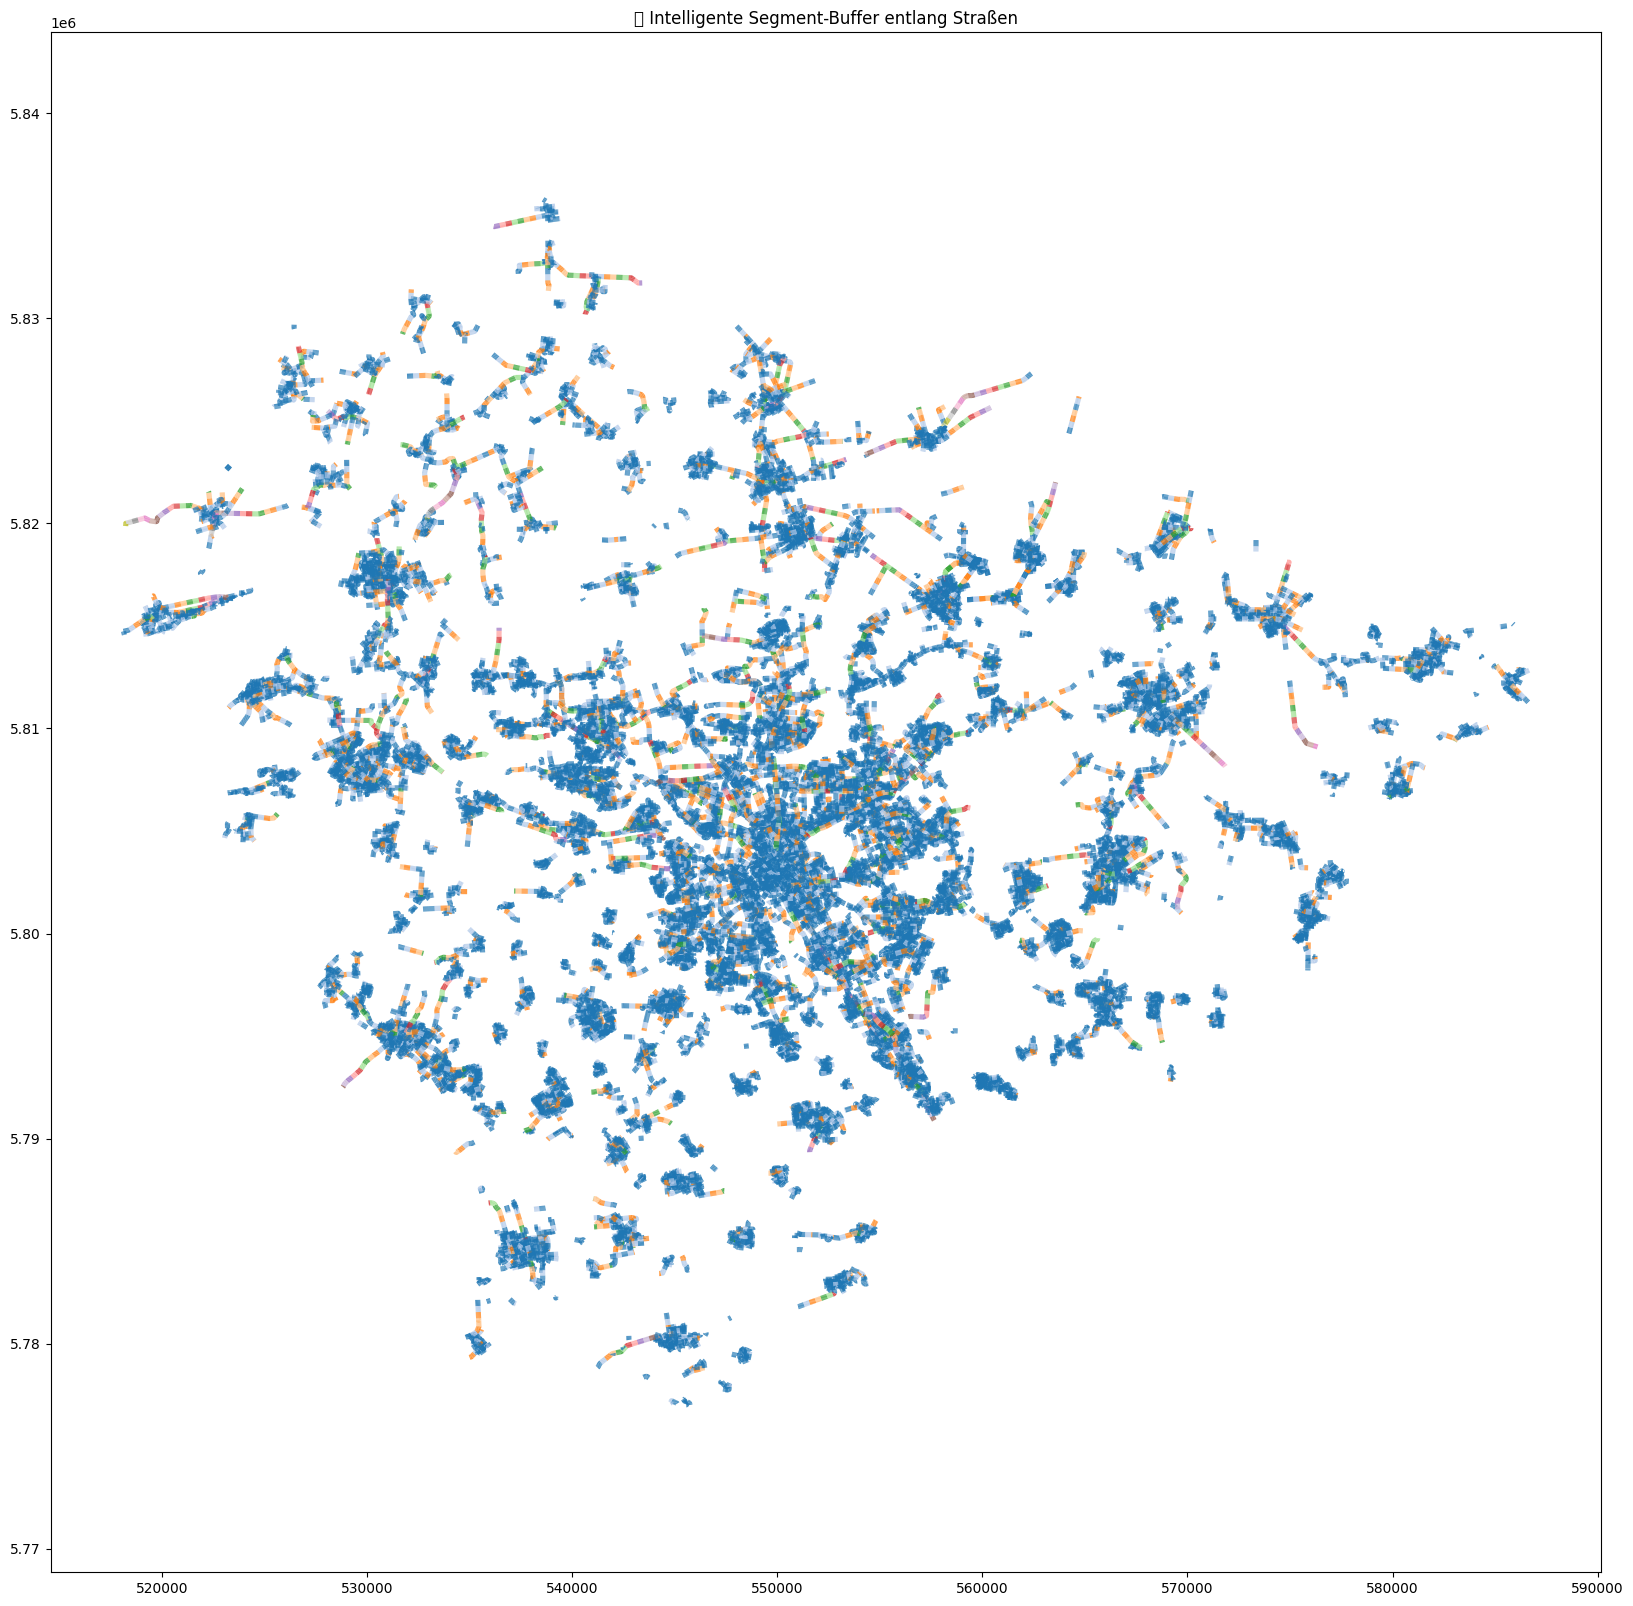

In [226]:
from shapely.geometry import LineString
from shapely.ops import substring
import geopandas as gpd
import numpy as np

from shapely.geometry import LineString, MultiLineString
from shapely.ops import substring
import geopandas as gpd
import numpy as np

def split_line_to_segments(line: LineString, segment_length: float = 50) -> list:
    """
    Splits a LineString into segments of fixed length.
    """
    segments = []
    distance = 0
    while distance < line.length:
        start = distance
        end = min(distance + segment_length, line.length)
        segment = substring(line, start, end)
        if not segment.is_empty:
            segments.append(segment)
        distance += segment_length
    return segments

def generate_rect_buffers_from_segments(
    dhl_streets_gdf: gpd.GeoDataFrame,
    segment_length: float = 50,
    buffer_width: float = 50
) -> gpd.GeoDataFrame:
    """
    Generates rectangular buffer geometries for fixed-length segments of street geometries,
    and stores the central point for later use.
    """
    segment_geoms = []
    meta_data = []

    for idx, row in dhl_streets_gdf.iterrows():
        geom = row.geometry
        name = row.get("name", f"Street_{idx}")
        plz = row.get("plz", None)
        dhl_weight = row.get("dhl_tag", None)

        lines = geom.geoms if isinstance(geom, MultiLineString) else [geom]

        for line_part in lines:
            if not isinstance(line_part, LineString):
                continue

            segments = split_line_to_segments(line_part, segment_length=segment_length)

            for i, segment in enumerate(segments):
                buffer_geom = segment.buffer(buffer_width / 2, cap_style=2)
                center_point = segment.interpolate(0.5, normalized=True)  # Punkt in der Mitte

                segment_geoms.append(buffer_geom)
                meta_data.append({
                    "str_idx": idx,
                    "seg_idx": i,
                    "name": name,
                    "plz": plz,
                    "line_segment": segment,
                    "point_geom": center_point,  # <--- gespeicherter Punkt
                    "dhl_weight": dhl_weight,
                })

    return gpd.GeoDataFrame(meta_data, geometry=segment_geoms, crs=dhl_streets_gdf.crs)


# Erzeuge segmentbasierte Buffer
buffered_samples_smart = generate_rect_buffers_from_segments(dhl_streets_gdf, segment_length=50, buffer_width=250)

buffered_samples_smart.plot(column="seg_idx", cmap="tab20", figsize=(20, 20), alpha=0.8)
plt.title("📏 Intelligente Segment-Buffer entlang Straßen")
plt.axis("equal")
plt.show()

In [227]:
from shapely.geometry.base import BaseGeometry


def assign_cells_to_samples(samples_gdf: gpd.GeoDataFrame, cells_gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Spatially joins each sample to the corresponding cell using the 'point_geom' column.
    Adds 'cell_id' to the samples.
    """

    assert "cell_id" in cells_gdf.columns, "cells_gdf must contain a 'cell_id' column"
    assert "point_geom" in samples_gdf.columns, "'samples_gdf' must contain a 'point_geom' column"

    # Sicherstellen, dass Geometrie stimmt
    if not isinstance(samples_gdf["point_geom"].iloc[0], BaseGeometry):
        samples_gdf["point_geom"] = gpd.GeoSeries(samples_gdf["point_geom"], crs=samples_gdf.crs)

    # Temporär Geometrie auf point_geom setzen
    samples_temp = samples_gdf.set_geometry("point_geom")

    # Spatial Join
    joined = gpd.sjoin(samples_temp, cells_gdf[["cell_id", "geometry"]], how="left", predicate="intersects")

    # Ursprüngliche Geometrie wiederherstellen
    joined = joined.set_geometry(samples_gdf.geometry.name)

    # Einheitliche cell_id-Spalte setzen
    if "cell_id_right" in joined.columns:
        joined["cell_id"] = joined["cell_id"].combine_first(joined["cell_id_right"])
        joined = joined.drop(columns=[col for col in joined.columns if col.startswith("cell_id_")])
    # joined = joined.drop(columns=[col for col in joined.columns if col.startswith("cell_id_")])

    return joined.drop(columns="index_right")

def assign_b2c_b2b_weights_with_total(
    buffered_samples: gpd.GeoDataFrame,
    companies_gdf: gpd.GeoDataFrame,
    persons_gdf: gpd.GeoDataFrame,
    ga_corrected_b2b_gdf: pd.DataFrame,
    alpha: float = 0.2,
    beta: float = 0.02,
    total_col: str = "total_coun",
    cell_id_col: str = "cell_id"
):
    """
    Erweiterte Gewichtung mit Total-Count pro Zelle als zusätzlichem Faktor.
    """

    samples = buffered_samples.copy()

    # B2C
    b2c_join = gpd.sjoin(samples, persons_gdf, how="left", predicate="contains")
    b2c_counts = b2c_join.groupby(b2c_join.index).size()
    samples["person_sum"] = b2c_join.groupby(b2c_join.index).size()
    samples["b2c_weight"] = samples.index.map(b2c_counts).fillna(0).astype(int)

    # B2B
    b2b_join = gpd.sjoin(samples, companies_gdf, how="left", predicate="contains")
    samples["company_count"] = samples.index.map(b2b_join.groupby(b2b_join.index).size()).fillna(0).astype(int)
    
    if "employees" in companies_gdf.columns:
        employees_sum = b2b_join.groupby(b2b_join.index)["employees"].sum()
        samples["employees_sum"] = samples.index.map(employees_sum).fillna(0).astype(int)
    else:
        samples["employees_sum"] = 0

    samples["b2b_weight"] = (
        alpha * samples["company_count"] +
        beta * samples["employees_sum"]
    )

    # Total-Paketmengen aus Zellen mappen
    # cell_count_map = ga_corrected_b2b_gdf.set_index(cell_id_col)[total_col].to_dict()
    # samples["total_count"] = samples[cell_id_col].map(cell_count_map).fillna(0)

    # # Gesamtgewichtung anwenden
    # samples["b2c_weight"] *= samples["total_count"] * 2
    # samples["b2b_weight"] *= samples["total_count"] * 2
    # Filter auf gültige Einträge
    mask = (samples["b2c_weight"] > 0) | (samples["b2b_weight"] > 0)
    return samples[mask].copy()



In [267]:
samples_weighted = assign_b2c_b2b_weights_with_total(
    buffered_samples=buffered_samples_smart,
    companies_gdf=companies_gdf,
    persons_gdf=persons_gdf,
    ga_corrected_b2b_gdf=ga_corrected_b2b_gdf,
    alpha=1,
    beta=0.01,
    total_col="total_coun",
    cell_id_col="cell_id"
)

In [268]:
def apply_dhl_boost_to_weights(
    samples_gdf, 
    str_idx_col="str_idx", 
    tag_col="dhl_weight", 
    boost_type="b2b", 
    min_tag=10
):
    """
    Addiert DHL-Tags als Mindestboost und skaliert zusätzlichen Boost proportional zur ursprünglichen Gewichtung.

    Parameters:
    -----------
    samples_gdf : GeoDataFrame
        Mit b2b_weight und/oder b2c_weight
    str_idx_col : str
        Straßen-ID
    tag_col : str
        Spalte mit DHL-Tag-Werten
    boost_type : str
        "b2b", "b2c" oder "both"
    min_tag : float
        Mindestwert für DHL-Tag, ab dem überhaupt geboostet wird
    """
    samples = samples_gdf.copy()

    def distribute_boost(group, weight_col):
        base_weight = group[weight_col]
        dhl_boost = group[tag_col] / 2  # Halbe Gewichtung für den Boost

        # Fallunterscheidung: keine Verteilung nötig
        if base_weight.sum() == 0:
            return dhl_boost

        # Ziel: final_weight = dhl + scaled(original)
        total_target = base_weight.sum() + dhl_boost.sum()

        # Proportionen der Originalgewichte
        proportions = base_weight / base_weight.sum()

        # Restgewicht nach DHL-Boost
        remaining_weight = total_target - dhl_boost

        # Endgewicht: DHL-Boost plus Anteil vom restlichen Gewicht
        final = dhl_boost + proportions * (total_target - dhl_boost.sum())

        return final

    if boost_type in ["b2b", "both"]:
        samples["b2b_weight"] = samples.groupby(str_idx_col, group_keys=False).apply(
            lambda g: distribute_boost(g, "b2b_weight")
        )

    if boost_type in ["b2c", "both"]:
        samples["b2c_weight"] = samples.groupby(str_idx_col, group_keys=False).apply(
            lambda g: distribute_boost(g, "b2c_weight")
        )

    return samples

samples_boosted = apply_dhl_boost_to_weights(
    samples_weighted, 
    boost_type="both", 
    min_tag=300
)

C:\Users\bienzeisler\AppData\Local\Temp\ipykernel_29284\1182929129.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  samples["b2b_weight"] = samples.groupby(str_idx_col, group_keys=False).apply(
C:\Users\bienzeisler\AppData\Local\Temp\ipykernel_29284\1182929129.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  samples["b2c_weight"] = samples.groupby(str_idx_col, group_keys=False).apply(


c:\Users\bienzeisler\Anaconda3\envs\matsim_geo_environment\lib\site-packages\geopandas\plotting.py:967: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.draw()
C:\Users\bienzeisler\AppData\Local\Temp\ipykernel_29284\3755417635.py:29: UserWarning: Glyph 128640 (\N{ROCKET}) missing from current font.
  plt.tight_layout()
c:\Users\bienzeisler\Anaconda3\envs\matsim_geo_environment\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bienzeisler\Anaconda3\envs\matsim_geo_environment\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


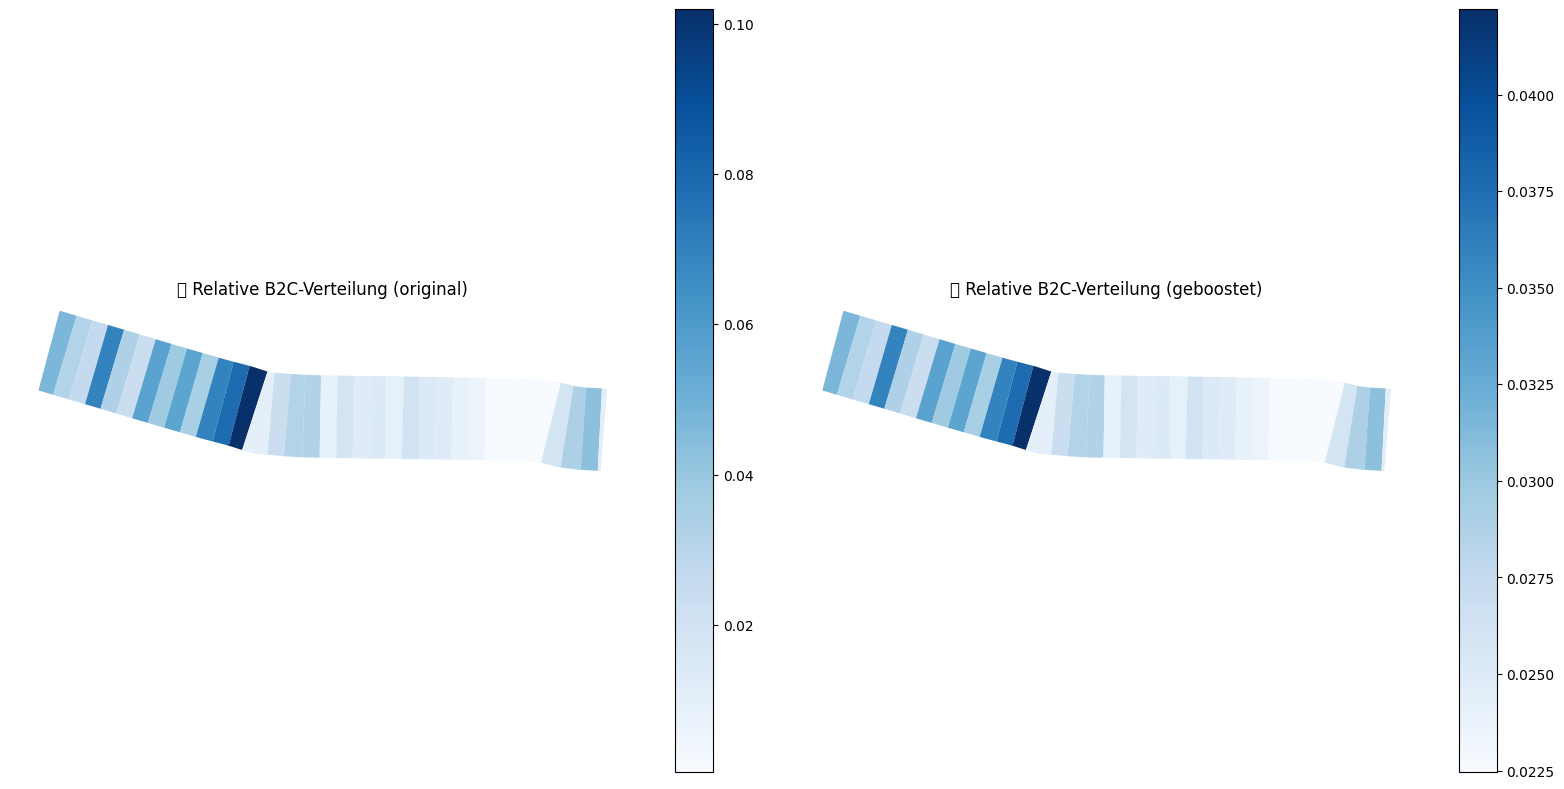

In [265]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Berechne relative Anteile pro Straße (oder Zelle)
samples_weighted["b2c_rel"] = samples_weighted.groupby("str_idx")["b2c_weight"].transform(lambda x: x / x.sum())
samples_boosted["b2c_rel"] = samples_boosted.groupby("str_idx")["b2c_weight"].transform(lambda x: x / x.sum())

# 📦 Links: ursprüngliche Verteilung (relativ)
samples_weighted[samples_weighted.str_idx == 3124].plot(
    column="b2c_rel",
    cmap="Blues",
    legend=True,
    ax=ax[0],
    linewidth=0
)
ax[0].set_title("📦 Relative B2C-Verteilung (original)")
ax[0].axis("off")

# 📦 Rechts: nach Boost
samples_boosted[samples_boosted.str_idx == 3124].plot(
    column="b2c_rel",
    cmap="Blues",
    legend=True,
    ax=ax[1],
    linewidth=0
)
ax[1].set_title("🚀 Relative B2C-Verteilung (geboostet)")
ax[1].axis("off")

plt.tight_layout()
plt.show()


c:\Users\bienzeisler\Anaconda3\envs\matsim_geo_environment\lib\site-packages\geopandas\plotting.py:967: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.draw()
C:\Users\bienzeisler\AppData\Local\Temp\ipykernel_29284\3165617914.py:27: UserWarning: Glyph 127981 (\N{FACTORY}) missing from current font.
  plt.tight_layout()
c:\Users\bienzeisler\Anaconda3\envs\matsim_geo_environment\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bienzeisler\Anaconda3\envs\matsim_geo_environment\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127981 (\N{FACTORY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


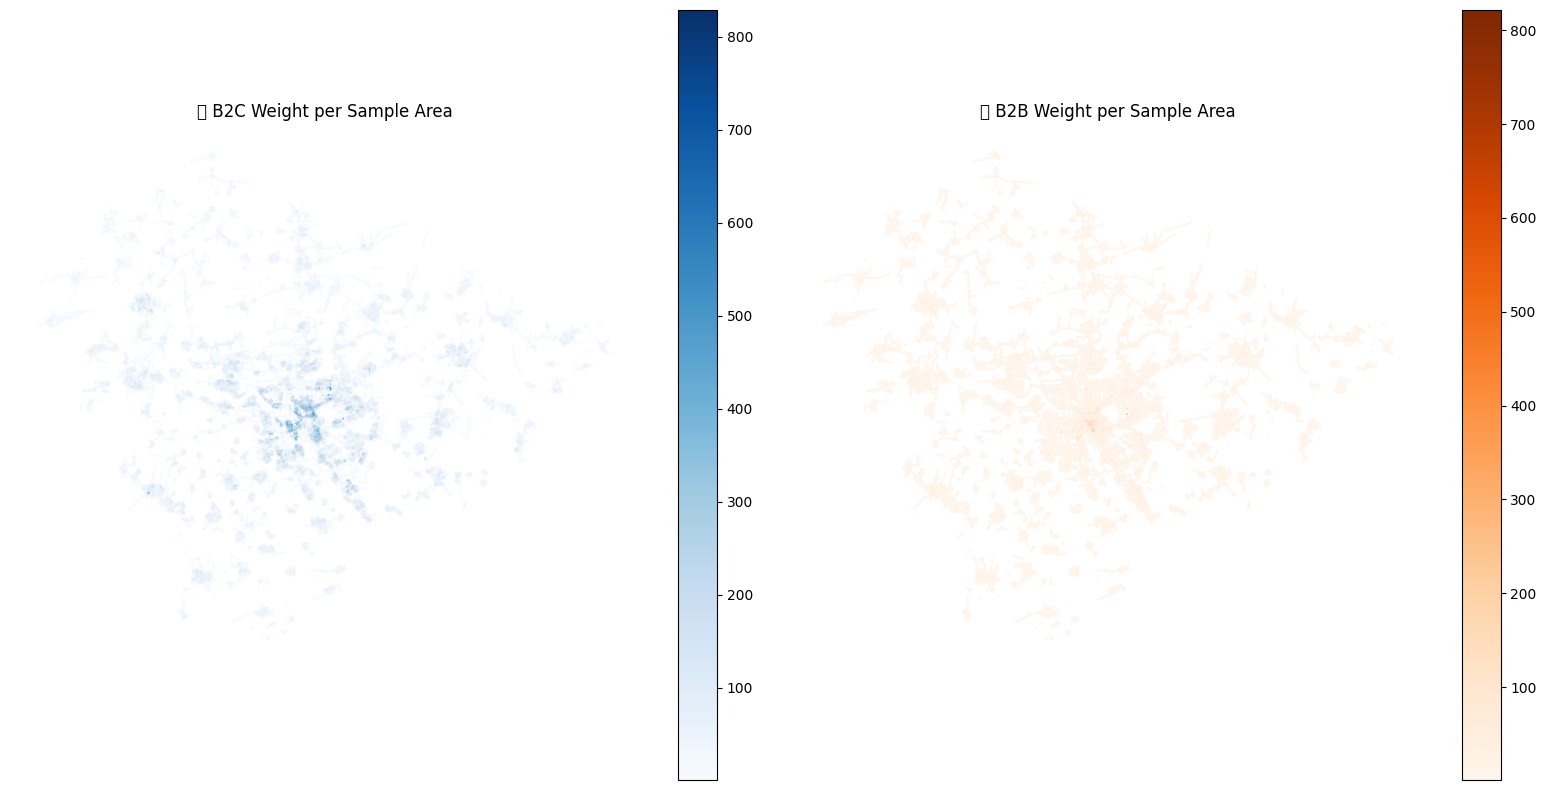

In [189]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# 📦 B2C
samples_weighted.plot(
    column="b2c_weight",
    cmap="Blues",
    legend=True,
    ax=ax[0],
    linewidth=0
)
ax[0].set_title("📦 B2C Weight per Sample Area")
ax[0].axis("off")

# 🏭 B2B
samples_weighted.plot(
    column="b2b_weight",
    cmap="Oranges",
    legend=True,
    ax=ax[1],
    linewidth=0
)
ax[1].set_title("🏭 B2B Weight per Sample Area")
ax[1].axis("off")

plt.tight_layout()
plt.show()


In [271]:
def calculate_relative_weights_per_street_extended(samples_weighted: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Calculates relative B2C and B2B weights per street segment based on sample rectangles,
    including geometry, PLZ, and street name. Adds optional global normalization [0–1].

    Parameters:
    -----------
    samples_weighted : GeoDataFrame
        GeoDataFrame with 'str_idx', 'b2c_weight', 'b2b_weight', 'plz', 'name', 'geometry'

    Returns:
    --------
    GeoDataFrame with:
        - sample_idx (original index)
        - str_idx
        - name
        - plz
        - geometry
        - b2c_ratio (relative to other samples on same street)
        - b2b_ratio
        - b2c_ratio_norm (normalized from 0 to 1 globally)
        - b2b_ratio_norm
    """
    assert "str_idx" in samples_weighted.columns
    assert "name" in samples_weighted.columns
    assert "plz" in samples_weighted.columns
    assert "geometry" in samples_weighted.columns

    result_rows = []

    for str_id, group in samples_weighted.groupby("str_idx"):
        b2c_total = group["b2c_weight"].sum()
        b2b_total = group["b2b_weight"].sum()

        for idx, row in group.iterrows():
            b2c_ratio = row["b2c_weight"]  if b2c_total > 0 else 0
            b2b_ratio = row["b2b_weight"]  if b2b_total > 0 else 0

            result_rows.append({
                "sample_idx": idx,
                "str_idx": str_id,
                "name": row["name"],
                "plz": row["plz"],
                "geometry": row["geometry"],
                "b2c_ratio": b2c_ratio,
                "b2b_ratio": b2b_ratio,
                "point_geom": row["point_geom"],  # Optional: point geometry for visualization
            })

    result_gdf = gpd.GeoDataFrame(result_rows, geometry="geometry", crs=samples_weighted.crs)

    return result_gdf


samples_with_ratios = calculate_relative_weights_per_street_extended(samples_boosted)
# samples_boosted
# samples_with_ratios =  calculate_relative_weights_per_street_extended(samples_boosted)


In [274]:
samples_with_ratios[samples_with_ratios.str_idx == 6858]

,sample_idx,str_idx,name,plz,geometry,b2c_ratio,b2b_ratio,point_geom,dhl_tag
63245,63245,6858,Am Berkhopsfeld,30938,"POLYGON ((556190.851 5815642.402, 556180.042 5...",3681.5,3681.50,POINT (556306.4390616134 5815690.757378455),7361
63246,63246,6858,Am Berkhopsfeld,30938,"POLYGON ((556163.954 5815721.549, 556400.660 5...",3681.5,3681.56,POINT (556290.3511120286 5815738.098458693),7361
63247,63247,6858,Am Berkhopsfeld,30938,"POLYGON ((556161.106 5815729.932, 556161.010 5...",3681.5,3683.61,POINT (556274.2996795062 5815785.451899939),7361
63248,63248,6858,Am Berkhopsfeld,30938,"POLYGON ((556131.889 5815816.584, 556368.786 5...",3681.5,3687.67,POINT (556258.3248084548 5815832.831257205),7361
63249,63249,6858,Am Berkhopsfeld,30938,"POLYGON ((556115.914 5815863.963, 556352.811 5...",3681.5,3682.54,POINT (556242.3499374036 5815880.210614471),7361
63250,63250,6858,Am Berkhopsfeld,30938,"POLYGON ((556112.385 5815874.429, 556111.280 5...",3681.5,3681.55,POINT (556226.7592171628 5815927.713340348),7361
63251,63251,6858,Am Berkhopsfeld,30938,"POLYGON ((556085.308 5815962.949, 556324.415 5...",3681.5,3689.81,POINT (556212.1607248527 5815975.534716554),7361
63252,63252,6858,Am Berkhopsfeld,30938,"POLYGON ((556070.710 5816010.771, 556309.816 5...",3681.5,3683.59,POINT (556197.5622325423 5816023.35609276),7361
63253,63253,6858,Am Berkhopsfeld,30938,"POLYGON ((556056.111 5816058.592, 556295.218 5...",3681.5,3684.73,POINT (556182.9637402319 5816071.177468967),7361
63254,63254,6858,Am Berkhopsfeld,30938,"POLYGON ((556054.464 5816063.986, 556053.303 5...",3681.5,3688.34,POINT (556168.9919079344 5816119.178669205),7361


<Axes: >

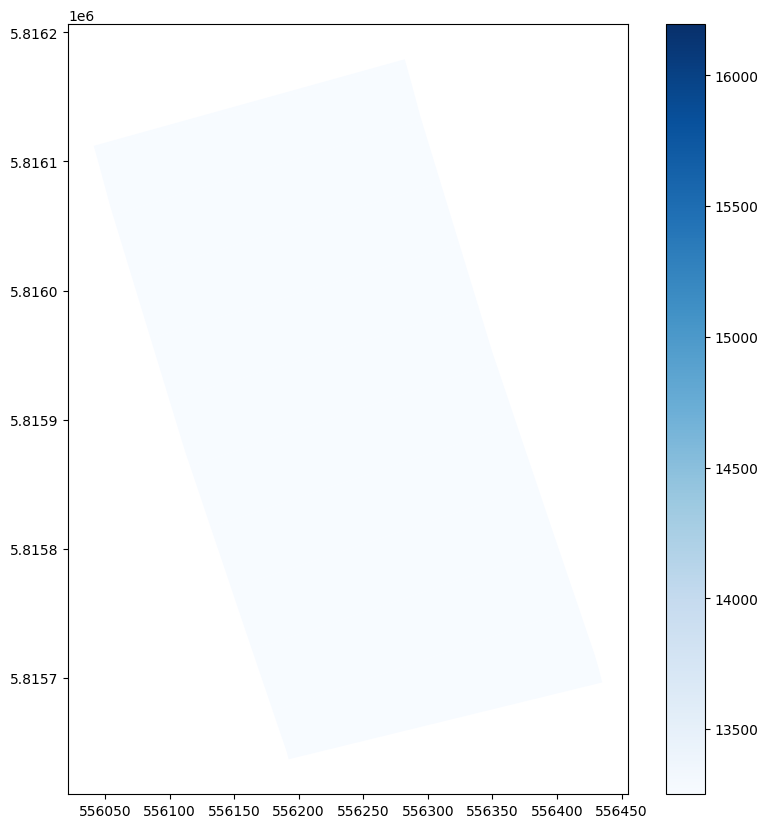

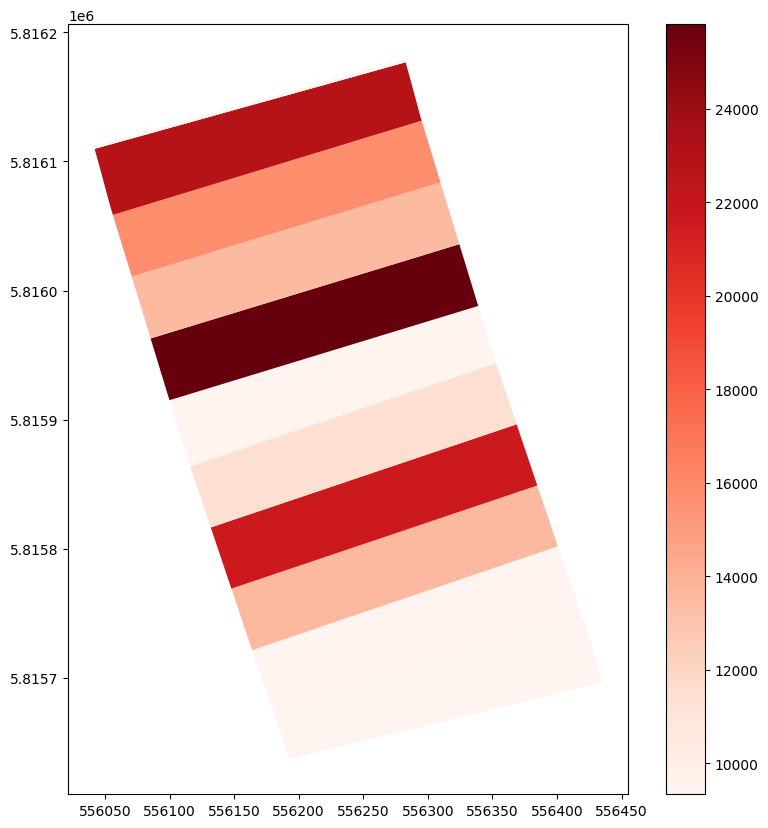

In [260]:

samples_with_ratios[samples_with_ratios.str_idx == 6858].plot(column="b2c_ratio", cmap="Blues", legend=True, figsize=(10, 10))
samples_with_ratios[samples_with_ratios.str_idx == 6858].plot(column="b2b_ratio", cmap="Reds", legend=True, figsize=(10, 10))

<Axes: >

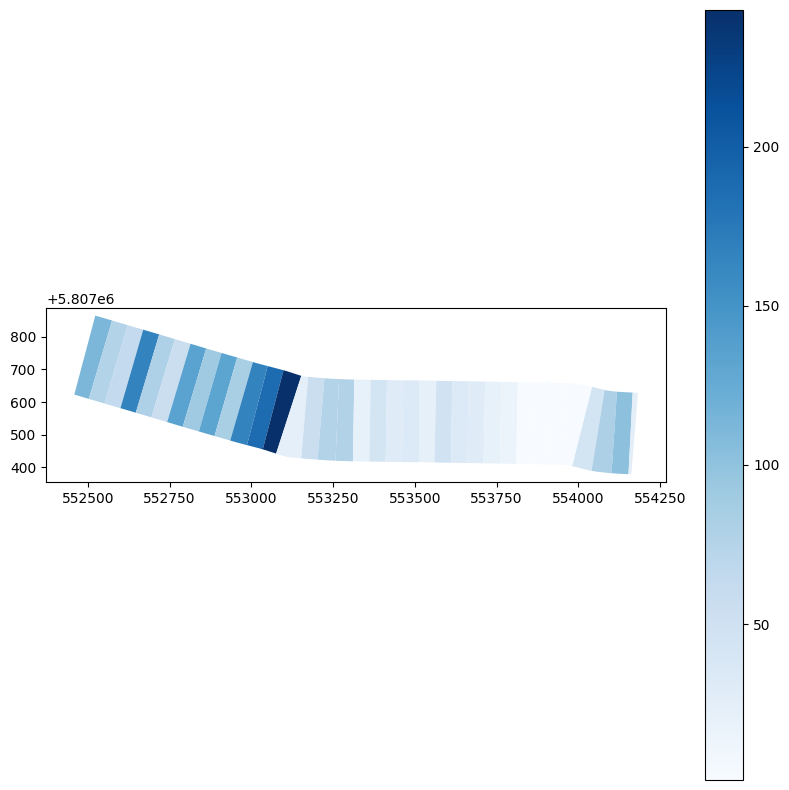

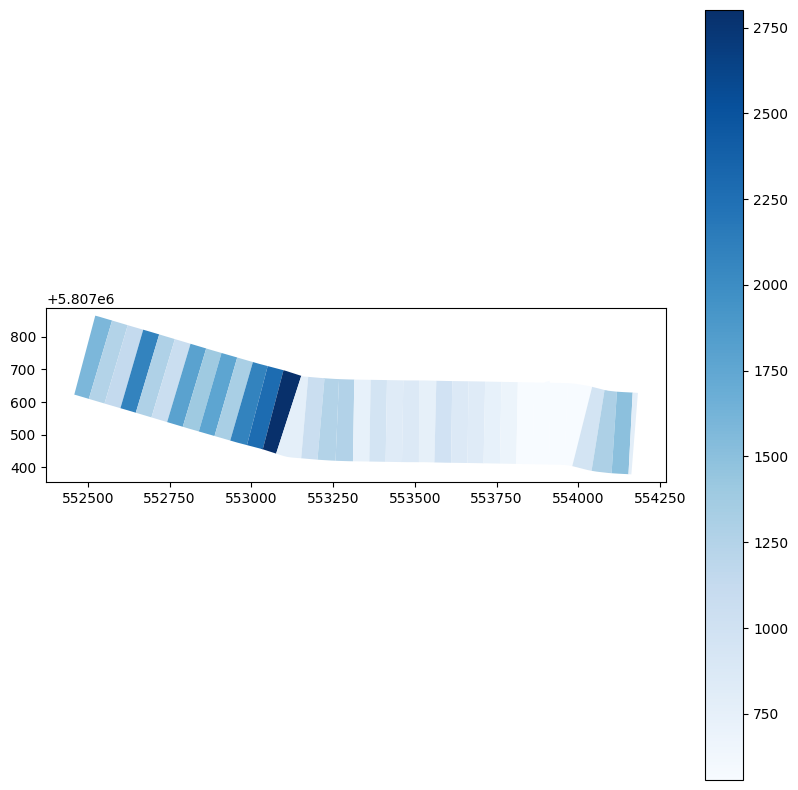

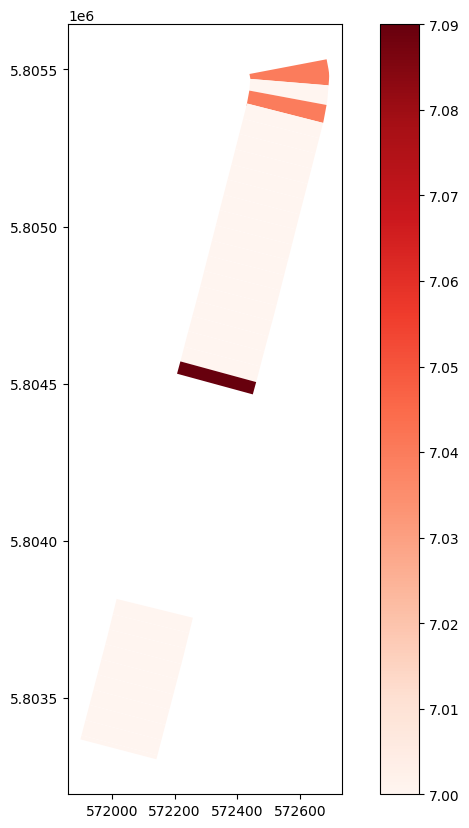

In [261]:
samples_weighted[samples_weighted.str_idx == 3124].plot(column="b2c_weight", cmap="Blues", legend=True, figsize=(10, 10))
samples_with_ratios[samples_with_ratios.str_idx == 3124].plot(column="b2c_ratio", cmap="Blues", legend=True, figsize=(10, 10))
samples_with_ratios[samples_with_ratios.str_idx == 8513].plot(column="b2b_ratio", cmap="Reds", legend=True, figsize=(10, 10))

<Axes: >

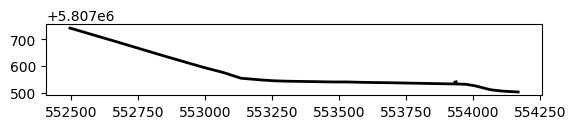

In [ ]:
dhl_streets_gdf[dhl_streets_gdf.index == 3124].plot(color="black", linewidth=2)

In [275]:
dhl_streets_gdf[dhl_streets_gdf.index == 3124]

,name,plz,dhl_tag,geometry
3124,Kugelfangtrift,30657,548,"MULTILINESTRING ((552490.374 5807743.558, 5524..."


In [272]:
def assign_dhl_volume_to_samples(samples: gpd.GeoDataFrame, dhl_streets_gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Merges the DHL volume per street segment into the samples using 'str_idx'.
    
    Parameters:
    -----------
    samples : GeoDataFrame
        Sample points or polygons with a 'str_idx' column referring to the street index.
    
    dhl_streets_gdf : GeoDataFrame
        Original DHL street segments with 'dhl_tag' (daily DHL volume), indexed by row position.
    
    Returns:
    --------
    GeoDataFrame with new column 'dhl_tag' added to samples.
    """
    # Sicherstellen, dass dhl_streets_gdf einen int-Index hat
    if not isinstance(dhl_streets_gdf.index, pd.RangeIndex):
        dhl_streets_gdf = dhl_streets_gdf.reset_index(drop=True)

    # Nur benötigte Spalten extrahieren
    dhl_volumes = dhl_streets_gdf[["dhl_tag"]].copy()
    dhl_volumes["str_idx"] = dhl_volumes.index  # Index als Spalte

    # Merge auf Basis von 'str_idx'
    merged = samples.merge(dhl_volumes, on="str_idx", how="left")

    return merged

samples_with_ratios = assign_dhl_volume_to_samples(samples_with_ratios, dhl_streets_gdf)

In [ ]:
samples_with_ratios.set_geometry("point_geom", inplace=True)

,sample_idx,str_idx,name,plz,geometry,b2c_ratio,b2b_ratio,point_geom,dhl_tag
0,0,0,Aegidienkirchhof,30159,"POLYGON ((550332.714 5802275.359, 550294.318 5...",199.5,29.92,POINT (550338.219166151 5802402.715881958),1
1,1,0,Aegidienkirchhof,30159,"MULTIPOLYGON (((550196.236 5802437.033, 550186...",50.5,24.80,POINT (550306.5324591172 5802386.120738771),1
2,2,1,Alexanderstraße,30159,"POLYGON ((550624.341 5802946.967, 550798.324 5...",23.5,38.98,POINT (550689.7951560242 5802846.469849583),7
3,3,1,Alexanderstraße,30159,"POLYGON ((550657.757 5802984.278, 550833.821 5...",21.5,48.92,POINT (550728.0405526278 5802877.9287071),7
4,4,1,Alexanderstraße,30159,"POLYGON ((550676.735 5803003.105, 550852.800 5...",4.5,19.20,POINT (550755.2783881983 5802904.948309565),7
...,...,...,...,...,...,...,...,...,...
112473,112473,12340,Ziegeleistraße,30855,"POLYGON ((546390.031 5809120.713, 546388.616 5...",28.0,24.16,POINT (546376.2468103293 5809245.455209435),40
112474,112474,12340,Ziegeleistraße,30855,"POLYGON ((546309.060 5809119.465, 546293.441 5...",22.0,22.09,POINT (546326.2807257995 5809243.630003441),40
112475,112475,12340,Ziegeleistraße,30855,"POLYGON ((546292.248 5809116.854, 546274.992 5...",26.0,24.76,POINT (546277.9707950901 5809241.1761926785),40
112476,112476,12341,Zur Schnittenriede,30855,"POLYGON ((550458.640 5814205.159, 550334.131 5...",47.5,3.50,POINT (550374.7065094034 5814109.215428539),5


In [273]:
samples_with_ratios.to_csv("output/06_street_samples_with_weights.csv", index=False)